## Measurement



In [1]:
library(tidyverse)
library(MASS)
library(dplyr)


load_install_package = function(package, apt=TRUE) {
  if (!require(package, character.only=T, quietly=T)) {
    if (apt) {
        apt_install(package)
    } else {
        install.packages(package)
    }
    library(package, character.only=T)
  }
}


apt_install = function(package){
  system2(command='apt-get',
          args=c('install', sprintf('r-cran-%s', tolower(package))))
}

packages_to_apt_install = c('lme4', 'lmerTest', 'gplots', 'caret', 'pROC')
for (package in packages_to_apt_install) load_install_package(package)

packages_to_install = c("GPArotation", 'psych', 'MBESS')
for (package in packages_to_install) load_install_package(package, apt=FALSE)


theme_set(theme_gray(base_size = 18))


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attachi

For several of the examples in this notebook we will use the openly shared data from [Eisenberg et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6534563/), which includes data from a large number of cognitive tests, psychological surveys, and demographic questionnaires.  

In [2]:
orig_data = read_csv('https://raw.githubusercontent.com/IanEisenberg/Self_Regulation_Ontology/master/Data/Complete_02-16-2019/meaningful_variables_noDDM.csv', show_col_types = FALSE)  %>%
  rename('subID' = `...1`)
retest_data = read_csv('https://raw.githubusercontent.com/IanEisenberg/Self_Regulation_Ontology/master/Data/Retest_02-16-2019/meaningful_variables_noDDM.csv', show_col_types = FALSE)   %>%
  rename('subID' = `...1`)
demog_data = read_csv('https://raw.githubusercontent.com/IanEisenberg/Self_Regulation_Ontology/master/Data/Complete_02-16-2019/demographic_health.csv', show_col_types = FALSE) %>%
  rename('subID' = `...1`) %>%
  mutate(everArrested = as.numeric(ArrestedChargedLifeCount > 0),
         SexFactor = recode_factor(Sex, `0` = 'Male', `1` = 'Female'))
brief_data = read_csv('https://github.com/IanEisenberg/Self_Regulation_Ontology/raw/master/Data/Complete_02-16-2019/Individual_Measures/brief_self_control_survey.csv.gz', show_col_types = FALSE)
brief_wide = brief_data %>%
  dplyr::select(worker_id, text, response) %>%
  pivot_wider(names_from=text, values_from=response) %>%
  rename(subID = worker_id) %>%
  drop_na()

matching_orig_data = orig_data %>%
  filter(subID %in% retest_data$subID)

matching_orig_data$test = 'test'
retest_data$test = 'retest'

all_data = rbind(matching_orig_data, retest_data)

all_data_wide = merge(matching_orig_data, retest_data, by = 'subID', suffixes = c('_test', '_retest'))

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


## Types of measurement scales

The concept of "measurement" generally refers to the mapping of observed relationships in the world to numbers.  A well-known framework for distinguishing different types of measurements comes from Stevens (1946) who laid out four different kinds of measurement scales. These distinctions are important because they relate to the kinds of mathematical operations that are reasonable to apply to values on each scale.

There are four different ways that a variable can differ; see [my online stats book](https://statsthinking21.github.io/statsthinking21-core-site/working-with-data.html#appendix) for more:

  - *Identity*: Each value of the variable has a unique meaning.
  - *Magnitude*: The values of the variable reflect different magnitudes and have an ordered relationship to one another – that is, some values are larger and some are smaller.
  - *Equal intervals*: Units along the scale of measurement are equal to one another. This means, for example, that the difference between 1 and 2 would be equal in its magnitude to the difference between 19 and 20.
  - *Absolute zero*: The scale has a true meaningful zero point. For example, for many measurements of physical quantities such as height or weight, this is the complete absence of the thing being measured.

### Nominal

A nominal variable satisfies the criterion of identity, such that each value of the variable represents something different, but the numbers simply serve as qualitative labels.  
For example, the demographic survey from Eisenberg et al. included the following question: "Do you have or have you ever been diagnosed with any of the following medical conditions (check all that apply)?" and provided a list of diseases to choose from:

```
            0: "Type II diabetes",
            1: " Metabolic Syndrome",
            2: " High Blood Pressure",
            3: " Heart Disease",
            4: " Stroke",
            5: " Cancer",
            6: " Sleep Apnea",
            7: " Other",
            8: " None"
```

There is no ordered relationship the different values; while they are labeled with numbers, the only mathematical operation that makes sense with these values is to count them.

We can look at the prevalence of each response:

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


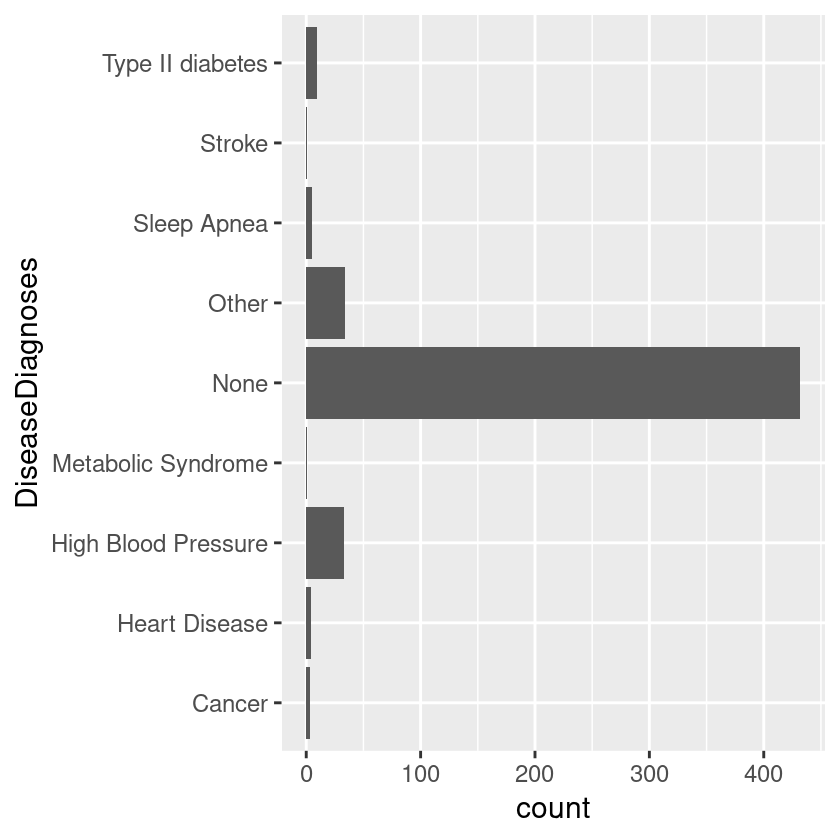

In [3]:
ggplot(demog_data, aes(DiseaseDiagnoses)) +
  geom_histogram(stat='count') +
    coord_flip()

### Ordinal

An ordinal variable satisfies the criteria of identity and magnitude, such that the values can be ordered in terms of their magnitude.

There are several variables in the Eisenberg et al. dataset that are treated ordinally.  Some of them are based on quantitative values, but treated in an ordinal way for the purposes of the survey.  For example, the question "How much car-related debt do you have?" had the following response alternatives:


```
1: <$500
2: $500-$2500
3: $2500-$10000
4: $10000-$25000
5: $25000-$50000
6: $50000-$100000
7: $100000-$200000
8: >$200000",
n/a: Prefer Not To Say
```

Here we see that the numbers map onto increasing amounts of debt, but that the different increments are not of the same size.  We can plot these using a histogram:

Warning message:
“Removed 25 rows containing non-finite values (`stat_bin()`).”


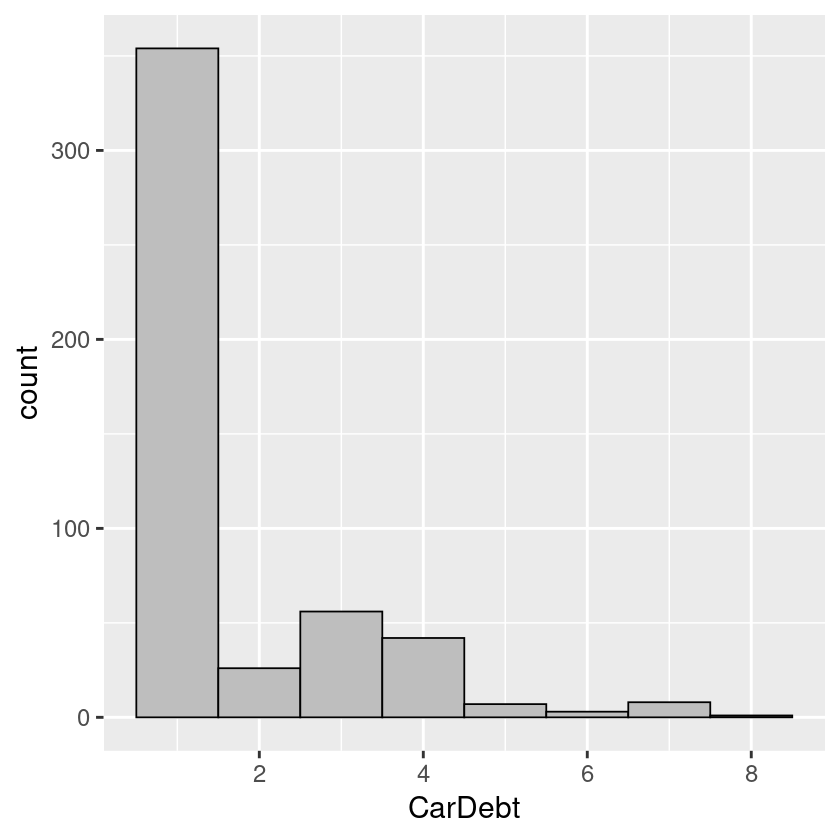

In [4]:
ggplot(demog_data, aes(CarDebt)) +
  geom_histogram(bins=8, fill = "gray", colour = "black")

In other cases, we have ordinal variables that are truly just an ordering, with no sense of the actual magnitudes. For example, the Brief Self-Control Survey asks the subject to rate themselves on items such as "I am good at resisting temptation." with the following rating scale:

```
1: Not at all: 1
2: 2
3: 3
4: 4
5: Very much: 5
```

In this case, it would make no sense to say that someone giving a "2" to this question has twice as much of some quantity as someone giving a "1".  We can also look at a histogram of these.

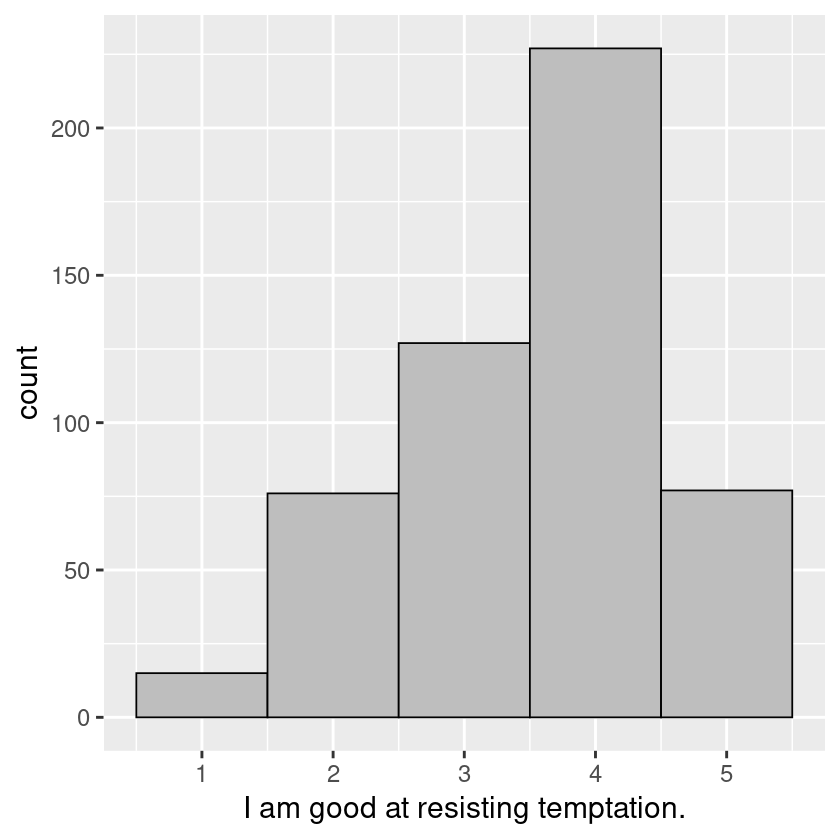

In [5]:
ggplot(brief_wide, aes(`I am good at resisting temptation.`)) +
  geom_histogram(bins=5, fill = "gray", colour = "black")

### Interval

An interval scale has all of the features of an ordinal scale, but in addition the intervals between units on the measurement scale can be treated as equal. A standard example is physical temperature measured in Celsius or Fahrenheit; the physical difference between 10 and 20 degrees is the same as the physical difference between 90 and 100 degrees, but each scale can also take on negative values.

We rarely encounter true interval data in psychology. However, ordinal data are often treated as interval because of the fact that interval data support addition and subtraction; since nearly all standard statistical techniques require this, it's common to simply assume that ordinal data can be treated as interval.  In general this seems to be ok since standard methods seem to be fairly robust (e.g. [Norman, 2010](https://link.springer.com/article/10.1007/s10459-010-9222-y) ) but it's always a good idea to check one's analyses to ensure that assumptions are not being violated.

For example, we might want to take the data from the previous example and ask how the ability to resist temptation differs between men and women in the dataset:



SexFactor,mean_temptation
<fct>,<dbl>
Male,3.576923
Female,3.477099


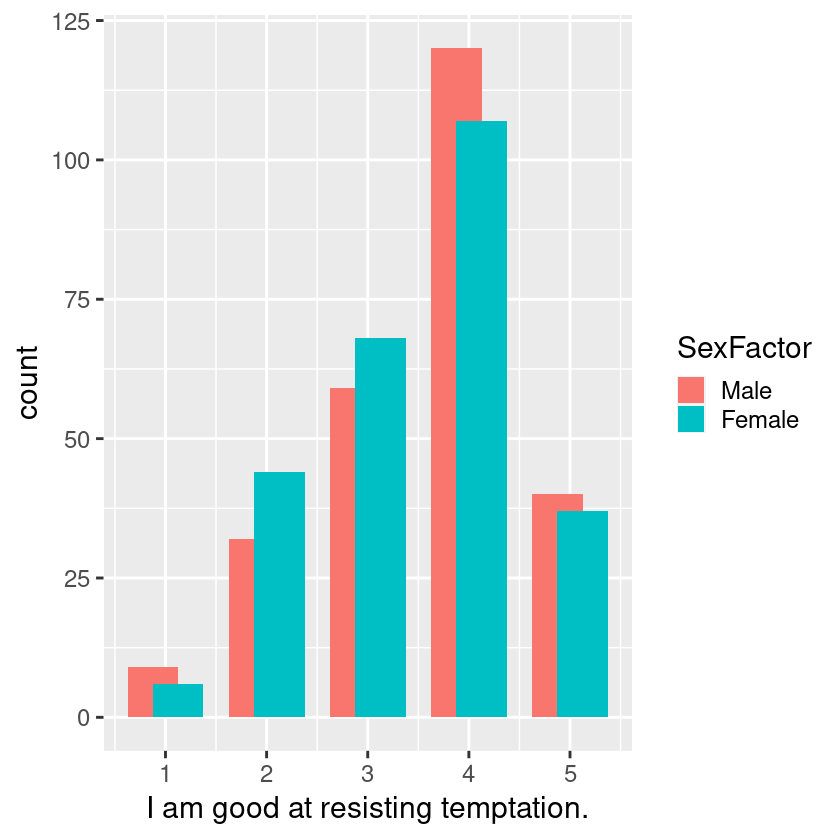

In [6]:
brief_wide_with_demog =  merge(y=demog_data, x=brief_wide, by = "subID", all.x = TRUE)

brief_wide_with_demog %>%
  group_by(SexFactor) %>%
  summarize(mean_temptation = mean(`I am good at resisting temptation.`))

ggplot(brief_wide_with_demog, aes(`I am good at resisting temptation.`, fill=SexFactor)) +
  geom_histogram(bins=5, position=position_dodge(0.5))

We can also perform statistics on these data, though in general it is best practice to use nonparametric statistics, such as those based on ranks rather than actual values.  For example, we could perform a standard t-test:

In [7]:
t.test(`I am good at resisting temptation.` ~ Sex, data=brief_wide_with_demog)


	Welch Two Sample t-test

data:  I am good at resisting temptation. by Sex
t = 1.1351, df = 519.97, p-value = 0.2569
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.07294432  0.27259200
sample estimates:
mean in group 0 mean in group 1 
       3.576923        3.477099 


But it would be more appropriate to use a nonparametric alternative to the t-test, such as a Wilcoxon signed rank test:

In [8]:
wilcox.test(`I am good at resisting temptation.` ~ Sex, data=brief_wide_with_demog)


	Wilcoxon rank sum test with continuity correction

data:  I am good at resisting temptation. by Sex
W = 36199, p-value = 0.1901
alternative hypothesis: true location shift is not equal to 0


In this case, the two tests give roughly the same answer.

### Ratio

A ratio scale variable has all four of the features outlined above: identity, magnitude, equal intervals, and absolute zero. The difference between a ratio scale variable and an interval scale variable is that the ratio scale variable has a true zero point. Examples of ratio scale variables include physical height and weight, along with temperature measured in Kelvin.

The main practical difference between ratio and interval scales is that while it doesn't make sense to divide interval variables (e.g. 64 degrees F is not twice as hot as 32 degrees F), you can reasonably divide ratio variables.

In psychology, commonly encountered ratio variables are time and counts/proportions.  For example, cognitive psychologists regularly measure response times, and it is also common to administer a number of items and then count the number that were successfully completed.

An example of a count variable is the item from the Eisenberg et al. dataset that asked what proportion of the 6 items on the Cognitive Reflection Test were correctly answered:

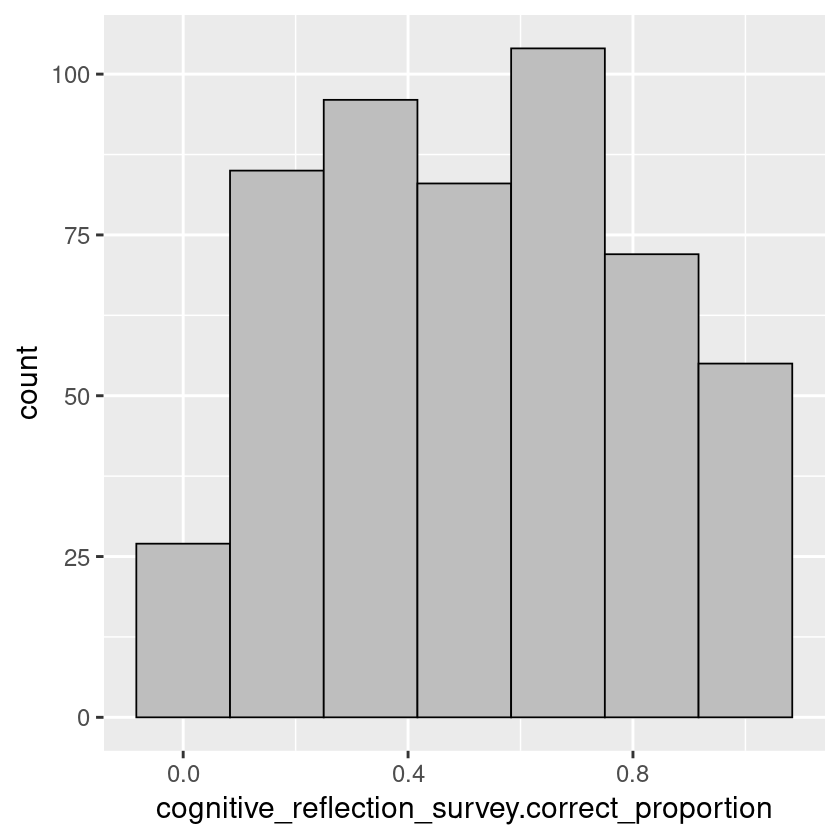

In [9]:
ggplot(orig_data, aes(cognitive_reflection_survey.correct_proportion)) +
  geom_histogram(bins=7, fill = "gray", colour = "black")

## Reliability

Reliability refers to the agreement or consistency of scores between two measures.

### Test-retest

Test-retest reliability quantifies the agreement of measurements when a test is administered twice. For example, in a study by [Enkavi et al., 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6431228/), a subset of 151  subjects from the Eisenberg et al. study were re-administered the entire battery several months after the initial test.  Let's compare the scores on one of the measures, the Raven's Progressive Matrices test which is a measure of fluid intelligence:

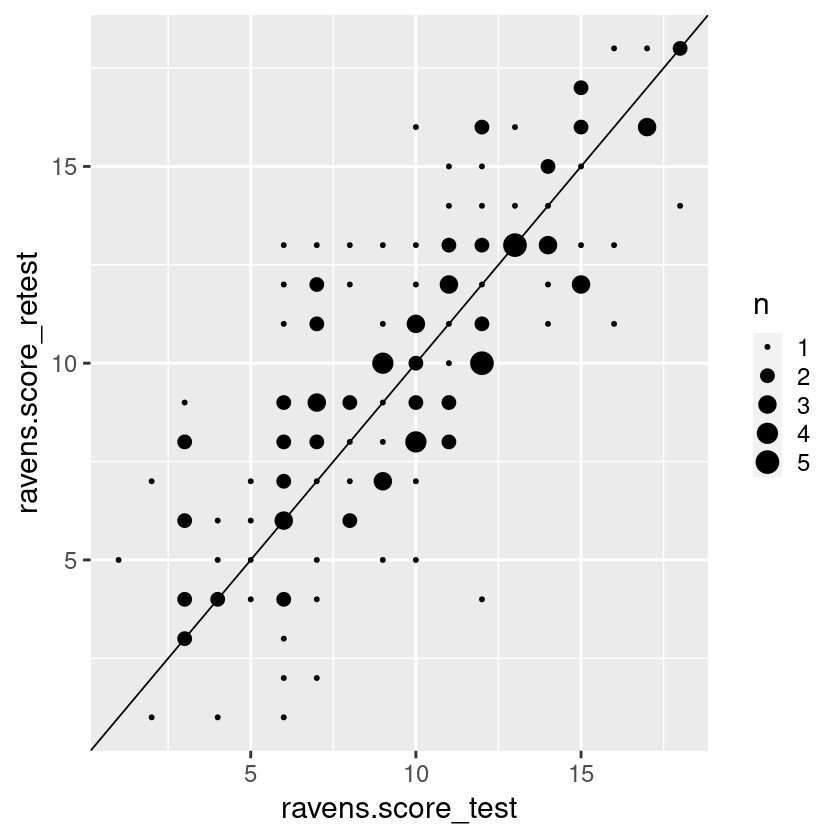

In [10]:
ggplot(all_data_wide, aes(x=ravens.score_test,
       y=ravens.score_retest)) +
        geom_count() +
      geom_abline(slope = 1)

Here it seems that the scores from the test and retest are in fairly good agreement, since they fall symmetrically around the line with a slope of 1.  We can compute the test-retest reliability using a measure called the *intraclass correlation coefficient*, or *ICC*.  This measure quantifies the relative amount of within-subject and between-subject variability.  There are a number of different versions of the ICC depending upon the specific situation; we will use "ICC3" whch is appropriate when we have a fixed number of levels (in this case, the two tests).

In [11]:
data = all_data_wide %>%
  dplyr::select(starts_with('ravens.score'))

icc_result = ICC(data, lmer=FALSE)
print(icc_result)


Call: ICC(x = data, lmer = FALSE)

Intraclass correlation coefficients 
                         type  ICC F df1 df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.78 8 149 150 3.4e-32        0.70        0.83
Single_random_raters     ICC2 0.78 8 149 149 2.9e-32        0.70        0.83
Single_fixed_raters      ICC3 0.78 8 149 149 2.9e-32        0.71        0.83
Average_raters_absolute ICC1k 0.87 8 149 150 3.4e-32        0.83        0.91
Average_random_raters   ICC2k 0.87 8 149 149 2.9e-32        0.83        0.91
Average_fixed_raters    ICC3k 0.88 8 149 149 2.9e-32        0.83        0.91

 Number of subjects = 150     Number of Judges =  2
See the help file for a discussion of the other 4 McGraw and Wong estimates,

The ICC value for the Raven's test is 0.78, which is generally interpreted as "good" reliability.

You might be asking: Why don't we just use the standard product-moment correlation coefficient?  The answer is that the standard correlation is not sensitive to differences in the mean or variability of the individual variables, such that the correlation can be very high even when the actual values between the two tests are quite different.  Let's generate some synthetic data to show this:

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


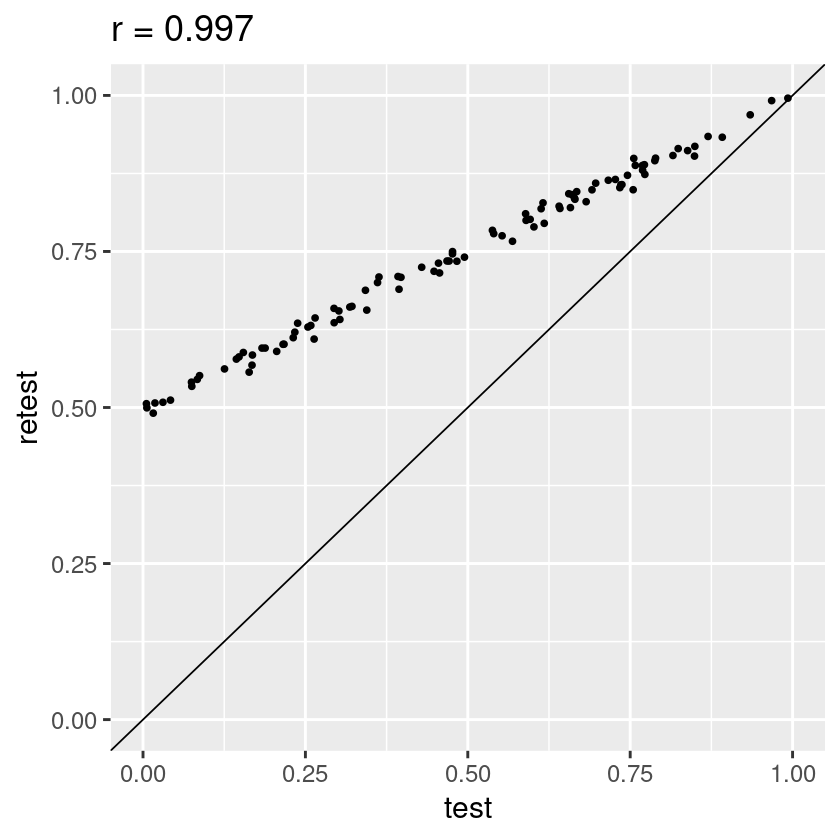

In [12]:
simdata = data.frame(test = runif(100)) %>%
  mutate(retest = .5 + test * 0.5 + rnorm(100, 0, 0.01))

ggplot(simdata, aes(test, retest)) +
  geom_point() +
  ggtitle(sprintf('r = %0.3f', cor(simdata)[1, 2])) +
  geom_abline(slope=1) +
  xlim(0, 1) + ylim(0, 1)

The correlation between these two tests is extremely high.  What about the ICC?

In [13]:
icc_result = ICC(simdata, lmer=FALSE)
print(icc_result)


Call: ICC(x = simdata, lmer = FALSE)

Intraclass correlation coefficients 
                         type  ICC   F df1 df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.32 1.9  99 100 5.2e-04       0.134        0.49
Single_random_raters     ICC2 0.46 9.0  99  99 5.1e-24      -0.089        0.78
Single_fixed_raters      ICC3 0.80 9.0  99  99 5.1e-24       0.717        0.86
Average_raters_absolute ICC1k 0.49 1.9  99 100 5.2e-04       0.236        0.65
Average_random_raters   ICC2k 0.63 9.0  99  99 5.1e-24      -0.195        0.88
Average_fixed_raters    ICC3k 0.89 9.0  99  99 5.1e-24       0.835        0.93

 Number of subjects = 100     Number of Judges =  2
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Here we see that the ICC3, while in the "good" range, is far below the standard correlation, due to the fact that scores changed their actual values fairly drastically for some of the subjects, even though the strong linear relationship (which is what the correlation coefficient indexes) remained.

### Interpreting reliability

It's tempting to think that a measure that has low reliability is a terrible measure, but the situation is more complicated.  Let's look at another example to see this.  The *Stroop task* is a commonly used cognitive task in which subjects are presented color words (like BLUE or GREEN) presented in different colors, and are asked to name the color that the word is presented in. Items are presented in two different conditions; *congruent* items are those where the word and color match (e.g. GREEN presented in green) while *incongruent*  items are those where the word and color are in conflict (e.g. GREEN presented in blue). The primary measure of interest is response times to name the color that the word is presented in.  

First let's look at response times on congruent trials across the two tests:

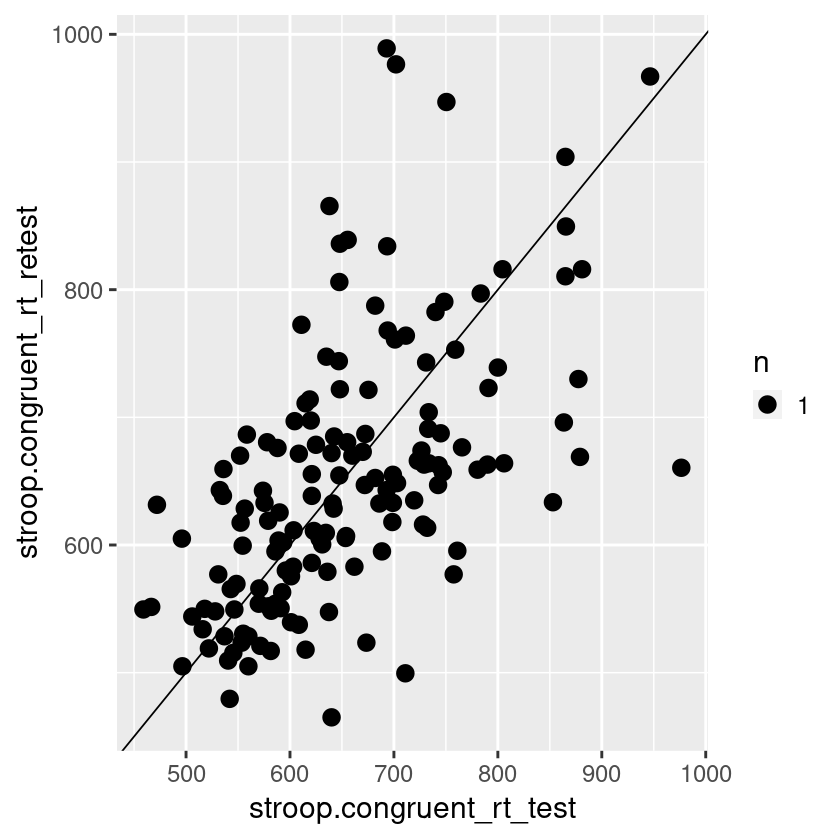

In [14]:
stroop_data = all_data_wide %>%
  dplyr::filter(stroop.congruent_rt_test < 1200)
ggplot(stroop_data, aes(x=stroop.congruent_rt_test,
       y=stroop.congruent_rt_retest)) +
        geom_count() +
      geom_abline(slope = 1)

In [15]:
data = stroop_data %>%
  dplyr::select(starts_with('stroop.congruent_rt'))

icc_result = ICC(data, lmer=FALSE)
print(icc_result)

Call: ICC(x = data, lmer = FALSE)

Intraclass correlation coefficients 
                         type  ICC   F df1 df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.57 3.7 147 148 8.7e-15        0.46        0.67
Single_random_raters     ICC2 0.57 3.7 147 147 1.3e-14        0.45        0.67
Single_fixed_raters      ICC3 0.57 3.7 147 147 1.3e-14        0.45        0.67
Average_raters_absolute ICC1k 0.73 3.7 147 148 8.7e-15        0.63        0.80
Average_random_raters   ICC2k 0.73 3.7 147 147 1.3e-14        0.62        0.80
Average_fixed_raters    ICC3k 0.73 3.7 147 147 1.3e-14        0.62        0.80

 Number of subjects = 148     Number of Judges =  2
See the help file for a discussion of the other 4 McGraw and Wong estimates,

We can do the same for the response times in the incongruent condition:

In [16]:
data = stroop_data %>%
  dplyr::select(starts_with('stroop.incongruent_rt'))

icc_result = ICC(data, lmer=FALSE)
print(icc_result)

Call: ICC(x = data, lmer = FALSE)

Intraclass correlation coefficients 
                         type  ICC   F df1 df2     p lower bound upper bound
Single_raters_absolute   ICC1 0.70 5.7 147 148 9e-24        0.61        0.77
Single_random_raters     ICC2 0.70 5.7 147 147 1e-23        0.61        0.77
Single_fixed_raters      ICC3 0.70 5.7 147 147 1e-23        0.61        0.78
Average_raters_absolute ICC1k 0.82 5.7 147 148 9e-24        0.76        0.87
Average_random_raters   ICC2k 0.82 5.7 147 147 1e-23        0.76        0.87
Average_fixed_raters    ICC3k 0.82 5.7 147 147 1e-23        0.76        0.87

 Number of subjects = 148     Number of Judges =  2
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Here we see that the ICC3 values for the response times in both conditions are in the moderate range.  

Response times on their own are difficult to interpret, so the primary interest in the Stroop task is the difference in response times between congruent and incongruent trials.  Let's look at those:

Warning message:
“Removed 1 rows containing non-finite values (`stat_sum()`).”


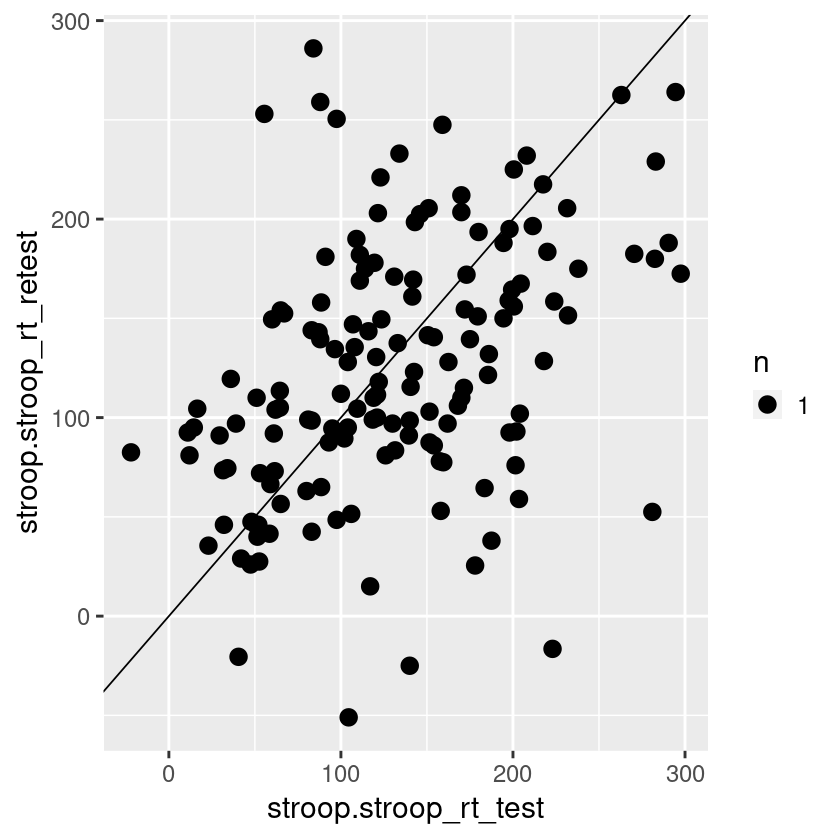

In [17]:
ggplot(all_data_wide, aes(x=stroop.stroop_rt_test,
       y=stroop.stroop_rt_retest)) +
        geom_count() +
      geom_abline(slope = 1)

The first thing to notice here is that nearly every subject shows a numerically positive stroop effect (99% for the initial test and 97% for the retest):

test,p_stroop_effect
<chr>,<dbl>
retest,0.9668874
test,0.9932886


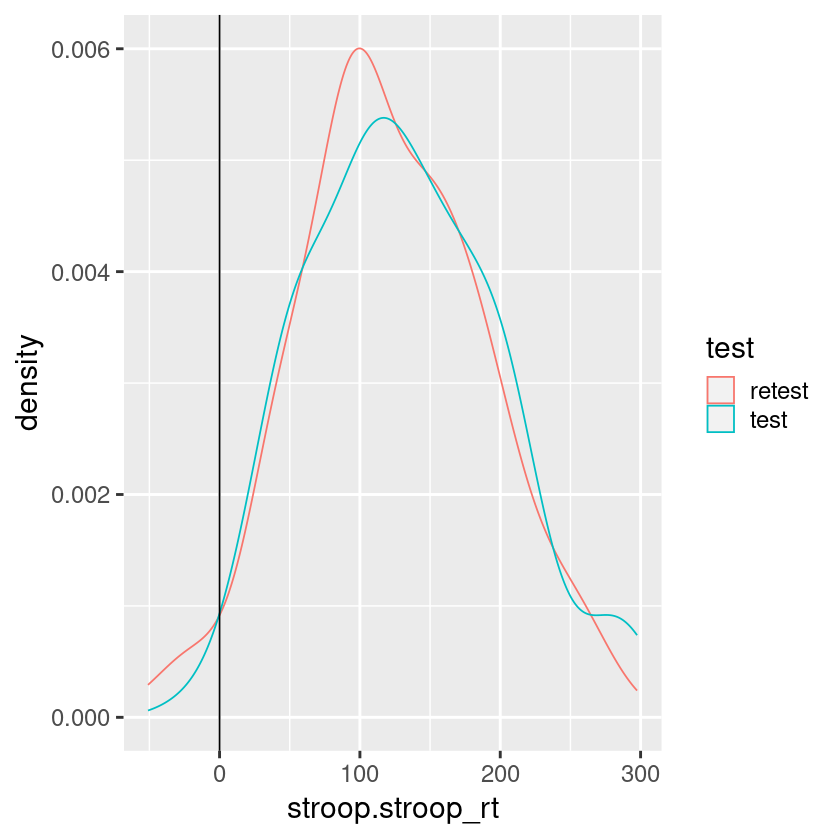

In [18]:
all_data %>%
  group_by(test) %>%
  drop_na(stroop.stroop_rt) %>%
  summarize(
    p_stroop_effect = mean(stroop.stroop_rt > 0)
  )

  ggplot(all_data %>% drop_na(stroop.stroop_rt), aes(stroop.stroop_rt, color=test)) +
    geom_density() +
      geom_vline(xintercept = 0)

Thus, the *presence* of the Stroop effect is highly reliable.  However, when we look at the ICC we see that it is substantially lower than the individual response times:

In [19]:
data = all_data_wide %>%
  dplyr::select(starts_with('stroop.stroop_rt')) %>%
  drop_na()

icc_result = ICC(data, lmer=FALSE)
print(icc_result)


Call: ICC(x = data, lmer = FALSE)

Intraclass correlation coefficients 
                         type  ICC   F df1 df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.40 2.3 148 149 2.4e-07        0.25        0.52
Single_random_raters     ICC2 0.40 2.3 148 148 2.4e-07        0.25        0.52
Single_fixed_raters      ICC3 0.40 2.3 148 148 2.4e-07        0.25        0.52
Average_raters_absolute ICC1k 0.57 2.3 148 149 2.4e-07        0.40        0.69
Average_random_raters   ICC2k 0.57 2.3 148 148 2.4e-07        0.40        0.69
Average_fixed_raters    ICC3k 0.57 2.3 148 148 2.4e-07        0.40        0.69

 Number of subjects = 149     Number of Judges =  2
See the help file for a discussion of the other 4 McGraw and Wong estimates,

This is due to a simple fact about how variances combine across variables. In particular, the variance of a difference (or sum) between two independent random variables is the sum of the variances of the individual variables (if they are not independent, then it's the sum minus 2 times the covariance):

In [20]:
x = rnorm(100, 0, 1)
y = rnorm(100, 0, 1)
d = x - y

paste('variance of x:', var(x))
paste('variance of x:', var(y))
paste('covariance of x and y:',cov(x,y))

var(x) + var(y) - 2 * cov(x,y)
var(d) 

[1] "variance of x: 0.950003588381571"

[1] "variance of x: 1.03972118551891"

[1] "covariance of x and y: 0.11262786909056"

[1] 1.764469

[1] 1.764469

Thus, when we compute difference scores between variables, we are amplifying the variability and will necessarily end up with a measure that has lower reliability.

The fact that measures can have highly reliable presence but weakly reliable magnitude has come to be called the *reliability paradox* in cognitive psychology ([Hedge et al., 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5990556/)).

### Reliability of different variable types

The study by Enkavi et al. examined how reliability differed between different types of measures, and found that survey measures in general showed much higher reliability that measures from cognitive tasks (which are usually measures of either response time or accuracy).  We can see that here:

In [21]:
# reliability for all variables

all_icc = c()

for (varname in names(all_data)) {
  if (!(varname %in% c('subID', 'test') )) {
    data = all_data_wide %>%
      dplyr::select(starts_with(varname)) %>%
      drop_na()
    if (dim(data)[1] > 100){
      if (length(grep('survey', varname)) > 0) {
        vartype = 'survey'
      } else {
        vartype = 'task'
      }
      lm_result = lm(data[, 1] ~ data[, 2])
      icc_result = ICC(data, lmer=FALSE)
      all_icc = rbind(all_icc, c(varname, vartype,
        as.numeric(icc_result$results['Single_fixed_raters','ICC']),
        lm_result$coefficients[2]))
    }
  }
}


In [22]:
icc_df = data.frame(all_icc)
names(icc_df) = c('varname', 'vartype', 'icc', 'slope')
icc_df$icc = as.numeric(icc_df$icc)

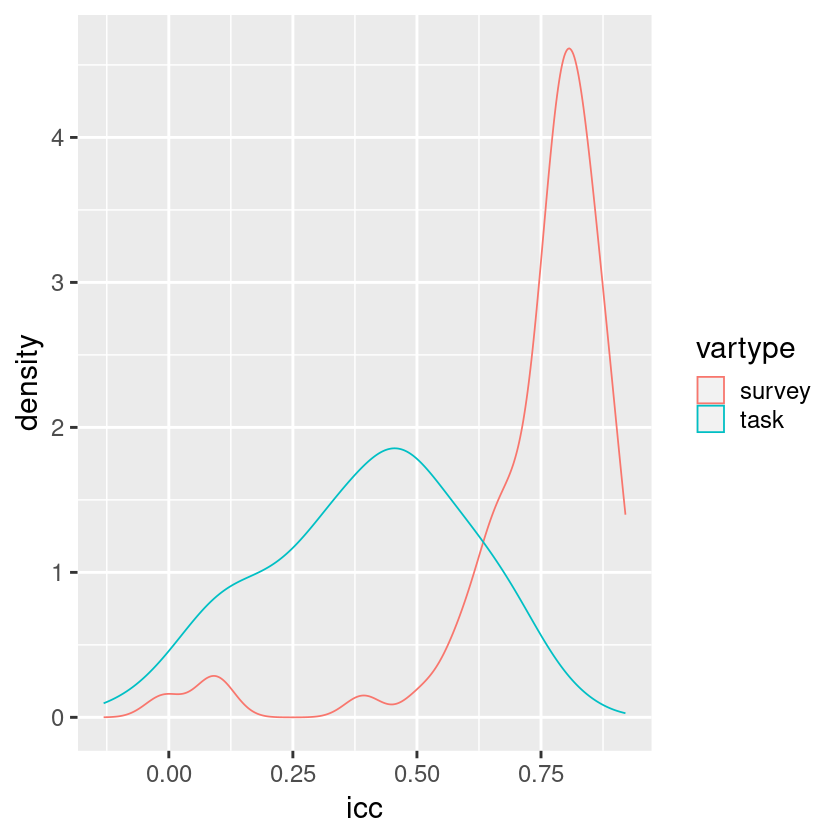

In [23]:
ggplot(icc_df, aes(icc, color=vartype)) +
  geom_density()

This probably reflects the fact that in order to publish a new survey, researchers are generally expected to include reliability metrics to show that the survey is reliable. However, in cognitive psychology, researchers are generally expected to show a significant effect (different from zero) but do not generally report reliability measures.

### Reliability bounds correlation

Why does reliability matter?  One reason is that the correlation between two variables is bounded by the reliability of those variables.  In classical test theory within psychology it's common to talk about a *true score* that is measured by observed variables that include noise.  That is, for two variables X and Y:

$X_{observed} = X_{true} + \epsilon$

$Y_{observed} = Y_{true} + \epsilon$

The correlation between the observed variables is a function of the correlation of the true scores and the reliability of the observed variables (specifically their geometric mean):

$
r\_obs_{xy} = r\_true_{xy} * \sqrt{r_{xx} * r_{yy}}
$

where $r_{xx}$ and $r_{yy}$ are the reliabilities of the x and y variables. Whenever the reliabilty of either score is less than one, the observed correlation will be *attenuated* compared to the true correlation.

We can simulate data to see this directly:

In [24]:
reliability_sim = function(r_xy_true = 0.5, n=100, noise_X=0.5, noise_Y=0.5){

  Sigma <- matrix(c(1,r_xy_true,r_xy_true,1),2,2)
  vars = mvrnorm(n, c(0, 0), Sigma, empirical = TRUE)

  df = data.frame(X_t = vars[, 1], Y_t = vars[, 2]) %>%
    mutate(
      X = X_t + rnorm(n, 0, noise_X),
      X_retest = X_t + rnorm(n, 0, noise_X),
      Y = Y_t + rnorm(n, 0, noise_Y),
      Y_retest = Y_t  + rnorm(n, 0, noise_Y)

    )

  r_xx = cor(df$X, df$X_retest)
  r_yy = cor(df$Y, df$Y_retest)
  r_xy = cor(df$X, df$Y)

  r_c = r_xy / sqrt(r_xx * r_yy)
  return(data.frame(list(r_xy_true=r_xy_true, noise_X=noise_X, noise_Y=noise_Y,
                         r_xx=r_xx, r_xy=r_xy, r_yy=r_yy, r_c=r_c)))
}

sim_results = c()
n_sims = 250

for (true_r in seq(0.1, 0.9, 0.1)){
  for (noise_X in seq(0.25, 1.25, 0.25)) {
    for (i in 1:n_sims){
      sim_results = rbind(sim_results, reliability_sim(true_r,
                          noise_Y = 1, noise_X=noise_X))
    }
  }
}


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 469 rows containing non-finite values (`stat_smooth()`).”


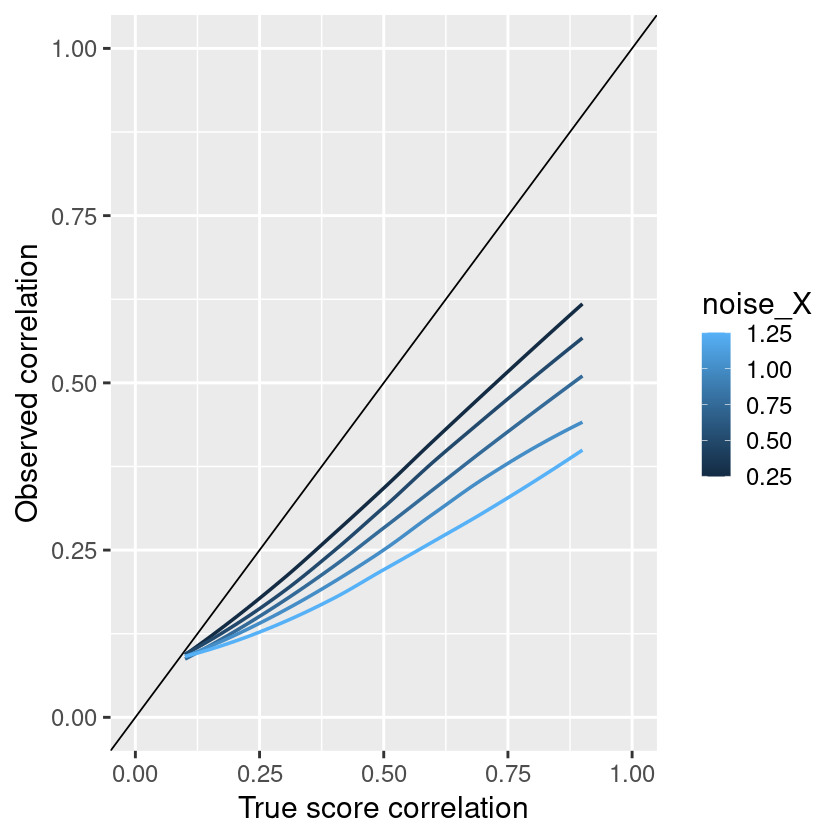

In [25]:
ggplot(sim_results, aes(x=r_xy_true, y=r_xy, group=noise_X, color=noise_X)) +
  geom_abline(slope=1) +
  geom_smooth(method='loess', se=FALSE) +
  xlim(c(0, 1)) +
  ylim(c(0,1)) +
  xlab('True score correlation') +
  ylab('Observed correlation')

Here we see that the observed correlation is attenuated compared to the true correlation.  If we know the reliability then we can apply a correction to the data to adjust for this attenuation, but this should only be used in cases where one is using correlations in an analysis that involves multiple variables with differing reliability (such as structural equation models).

The main point here is that reliability is very important any time we want to compute correlations between different variables. This is in fact the reason that the "reliability paradox" has received so much attention in recent years in the cognitive psychology literature: It has become much more common to look at individual differences in cognitive measures, which involves computing correlations between cognitive variables across subjects.  Measures that are extremely good at finding overall effects (like the Stroop measure shown above) can nonetheless have low reliability of their magnitudes, making them terrible for computing individual differences.

### Repeated measures and reliability

It is common in psychological studies to collect data on a large number of trials or items within a task, and then average across those items to compute a score for the each individual.  The reliability of the resulting score is directly related to the number of measurements that go into computing the score.

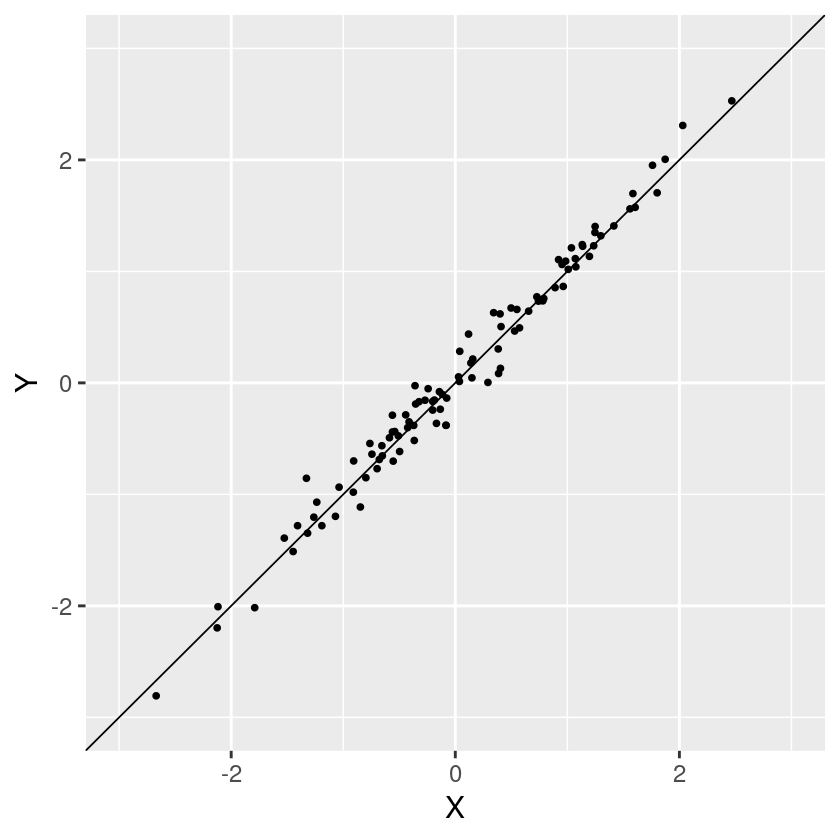

In [26]:
simulate_subject = function(bw_mean, bw_sd, win_sd, ntrials){
  submean = rnorm(1, bw_mean, bw_sd)
  simdata = data.frame(
    X = rnorm(ntrials, submean, win_sd),
    Y = rnorm(ntrials, submean, win_sd)
  )
  return(apply(simdata, 2, mean))
}

simulate_study = function(bw_mean, bw_sd, win_sd, ntrials, nsubjects){
  sim_subjects = c()
  for (i in 1:nsubjects){
    sim_subjects = rbind(sim_subjects, simulate_subject(bw_mean, bw_sd, win_sd, ntrials))
  }
  return(as.data.frame(sim_subjects))
}

simulate_study(bw_mean = 0, bw_sd = 1, win_sd = 1, ntrials = 100, nsubjects = 100) %>%
  ggplot(aes(X, Y)) +
  geom_point() +
  geom_abline(slope=1) +
  xlim(c(-3, 3)) +
  ylim(c(-3, 3))


In [27]:
sim_results = c()
nsubjects = 100
bw_sd = 15
win_sd = 100
nsims = 100 
nsubjects = 100

for (ntrials in c(10, 50, 100, 500, 1000)){
  for (i in 1:nsims){
  simdata = simulate_study(100, bw_sd, win_sd, ntrials, nsubjects) 
  sim_results = rbind(sim_results, c(ntrials, ICC(simdata, lmer=FALSE)$results['Single_fixed_raters','ICC']))
  }
}


In [28]:
sim_results_df = data.frame(sim_results)
names(sim_results_df) = c('ntrials', 'icc')

sim_results_df %>%
    group_by(ntrials) %>%
    summarize_all(mean)

ntrials,icc
<dbl>,<dbl>
10,0.1857901
50,0.5263909
100,0.6844662
500,0.9183808
1000,0.9558708


Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”


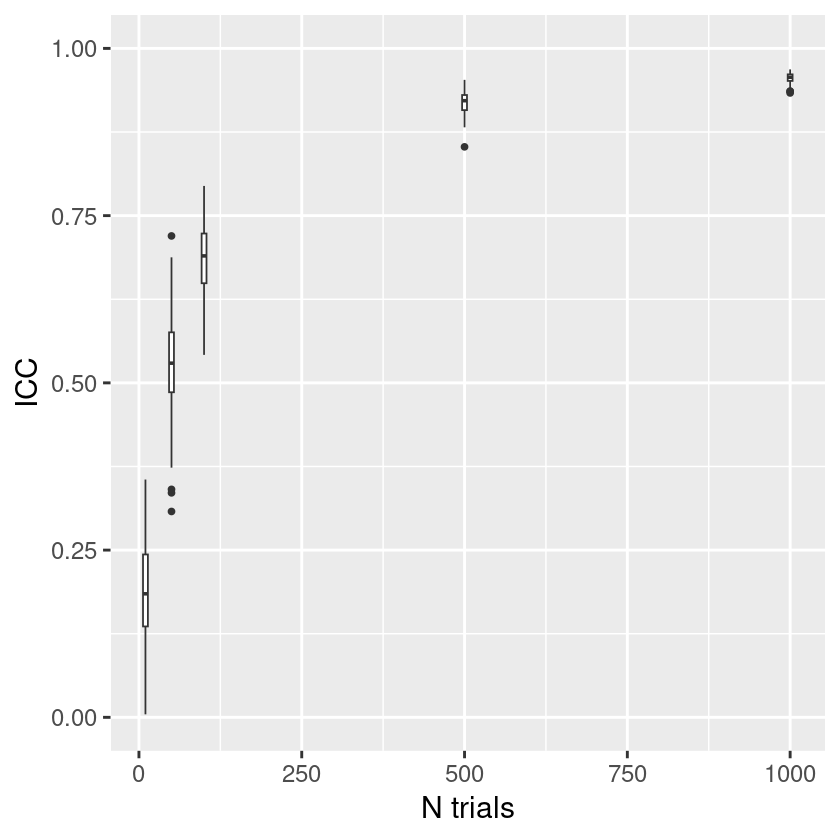

In [29]:
ggplot(sim_results_df, aes(ntrials, icc, group=ntrials)) +
  geom_boxplot() +
  ylim(c(0, 1)) +
  xlab('N trials') +
  ylab('ICC')

We can actually predict the reliability for a certain number of measurements given reliability for a different number of measurements using the *Spearman-Brown prophecy formula*:

$$
\rho_{x x^{\prime}}^{\ast}=\frac{n\rho_{x x^{\prime}}}{1+(n-1)\rho_{x x^{\prime}}}
$$

Let's predict the reliability for our simulated data for each number of trials, given the reliability for 10 trials:


Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”


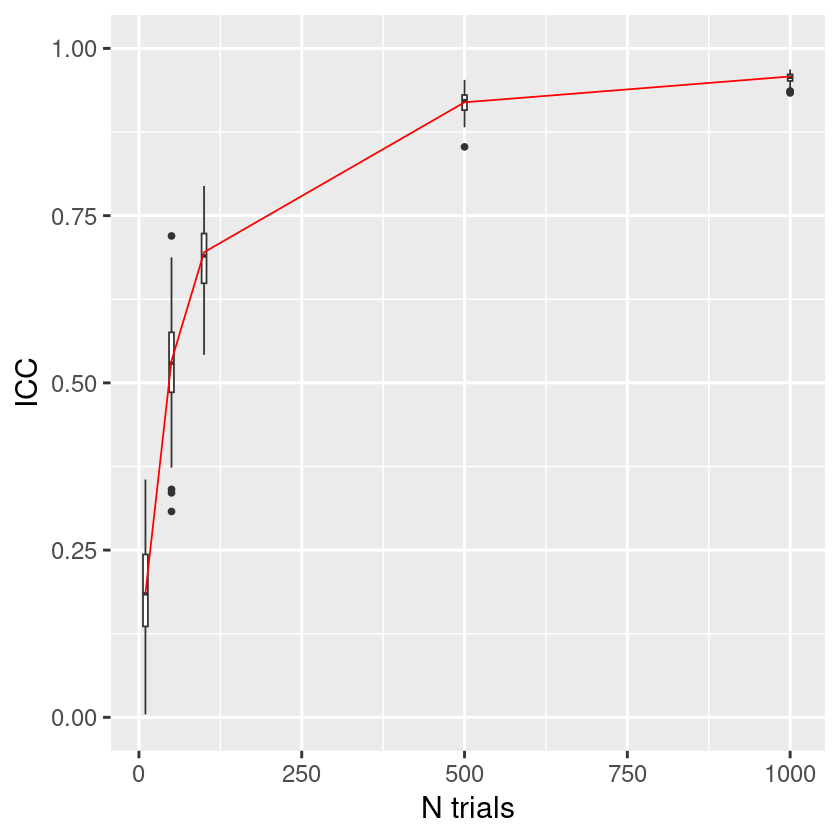

In [30]:
mean_icc_10 = mean(sim_results_df[sim_results_df$ntrials == 10,]$icc)
sim_results_df = sim_results_df %>%
  mutate(pred_icc = ((ntrials/10) * mean_icc_10)/(1 + (ntrials/10 - 1) * mean_icc_10 ))

ggplot(sim_results_df, aes(ntrials, icc, group=ntrials)) +
  geom_boxplot() +
  ylim(c(0, 1)) +
  xlab('N trials') +
  ylab('ICC') + 
  geom_line(aes(ntrials, pred_icc, group=1), color='red')

### Internal consistency

Internal consistency refers to the degree to which different items within a test are consistent with one another. *Chronbach's alpha* is often used as a measure of internal consistency but it has a number of problems; see [MacNeish, 2018](https://pubmed.ncbi.nlm.nih.gov/28557467/) for more. Here we will use a measure called *omega total* that is similar to Chronbach's alpha but has fewer assumptions (alpha is actually a special case of omega total when particular assumptions are met).

Let's first look at an established survey, the Brief Survey of Self-Control ([Tangney et al., 2004](https://pubmed.ncbi.nlm.nih.gov/15016066/)).  This survey includes 13 items that aim to measure the general construct of self-control.  



In [31]:
brief_wide_items = brief_wide %>%
    dplyr::select(-subID)

names(brief_wide_items)

# MBESS chokes on the variable names so replace them with something simple
names(brief_wide_items) = items <- paste("X", 1:dim(brief_wide_items)[2], sep = "")


[1] "I am good at resisting temptation."                                             
 [2] "I have a hard time breaking bad habits."                                        
 [3] "I am lazy."                                                                     
 [4] "I say inappropriate things."                                                    
 [5] "I do certain things that are bad for me, if they are fun."                      
 [6] "I refuse things that are bad for me."                                           
 [7] "I wish I had more self-discipline."                                             
 [8] "People would say that I have iron self-discipline."                             
 [9] "Pleasure and fun sometimes keep me from getting work done."                     
[10] "I have trouble concentrating."                                                  
[11] "I am able to work effectively toward long-term goals."                          
[12] "Sometimes I can't stop myself from doing something, even if I know it is wrong."
[13] "I often act without thinking through all the alternatives."

In [32]:
ci.reliability(data = brief_wide_items, type='omega', interval.type = 'mlr')

$est
[1] 0.9153064

$se
[1] 0.005748592

$ci.lower
[1] 0.9040393

$ci.upper
[1] 0.9265734

$conf.level
[1] 0.95

$type
[1] "omega"

$interval.type
[1] "robust maximum likelihood (wald ci)"

In this case we see that the internal consistency is very high, suggesting that the items are all measuring similar constructs.  This is consistent with previous research that had shown high internal consistency for this measure, including using the same dataset that we are using here ([Manapat et al., 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7261631/)).




## Validity

###  Convergent and divergent validity

*Convergent validity* reflects the fact that variables measuring the same construct should be related to one another.  *Divergent validity* is the opposite: variables measuring different constructs should be unrelated to one another.

Let's test this using some of the Eisenberg et al. data.  We will compare two sets of variables. One comes from a set of surveys that aim to measure the construct of *impulsivity*, which is the preference for short-term rewards over long-term goals. A second set comes from measures of *working memory*, which involve holding information in mind over time and manipulating it.  We think these are distinct constructs, so they should exhibit both convergent validity within the construct and divergent validity between the constructs.

Let's compute the correlation matrix for these variables and plot it using a heatmap.  We will also cluster the heatmap so that similar variables are close to one another:

[1] "bis11_survey.Attentional"                     
 [2] "bis11_survey.Motor"                           
 [3] "bis11_survey.Nonplanning"                     
 [4] "dickman_survey.dysfunctional"                 
 [5] "dickman_survey.functional"                    
 [6] "impulsive_venture_survey.impulsiveness"       
 [7] "impulsive_venture_survey.venturesomeness"     
 [8] "upps_impulsivity_survey.lack_of_perseverance" 
 [9] "upps_impulsivity_survey.lack_of_premeditation"
[10] "upps_impulsivity_survey.negative_urgency"     
[11] "upps_impulsivity_survey.positive_urgency"     
[12] "upps_impulsivity_survey.sensation_seeking"    
[13] "digit_span.forward_span"                      
[14] "digit_span.reverse_span"                      
[15] "spatial_span.forward_span"                    
[16] "spatial_span.reverse_span"

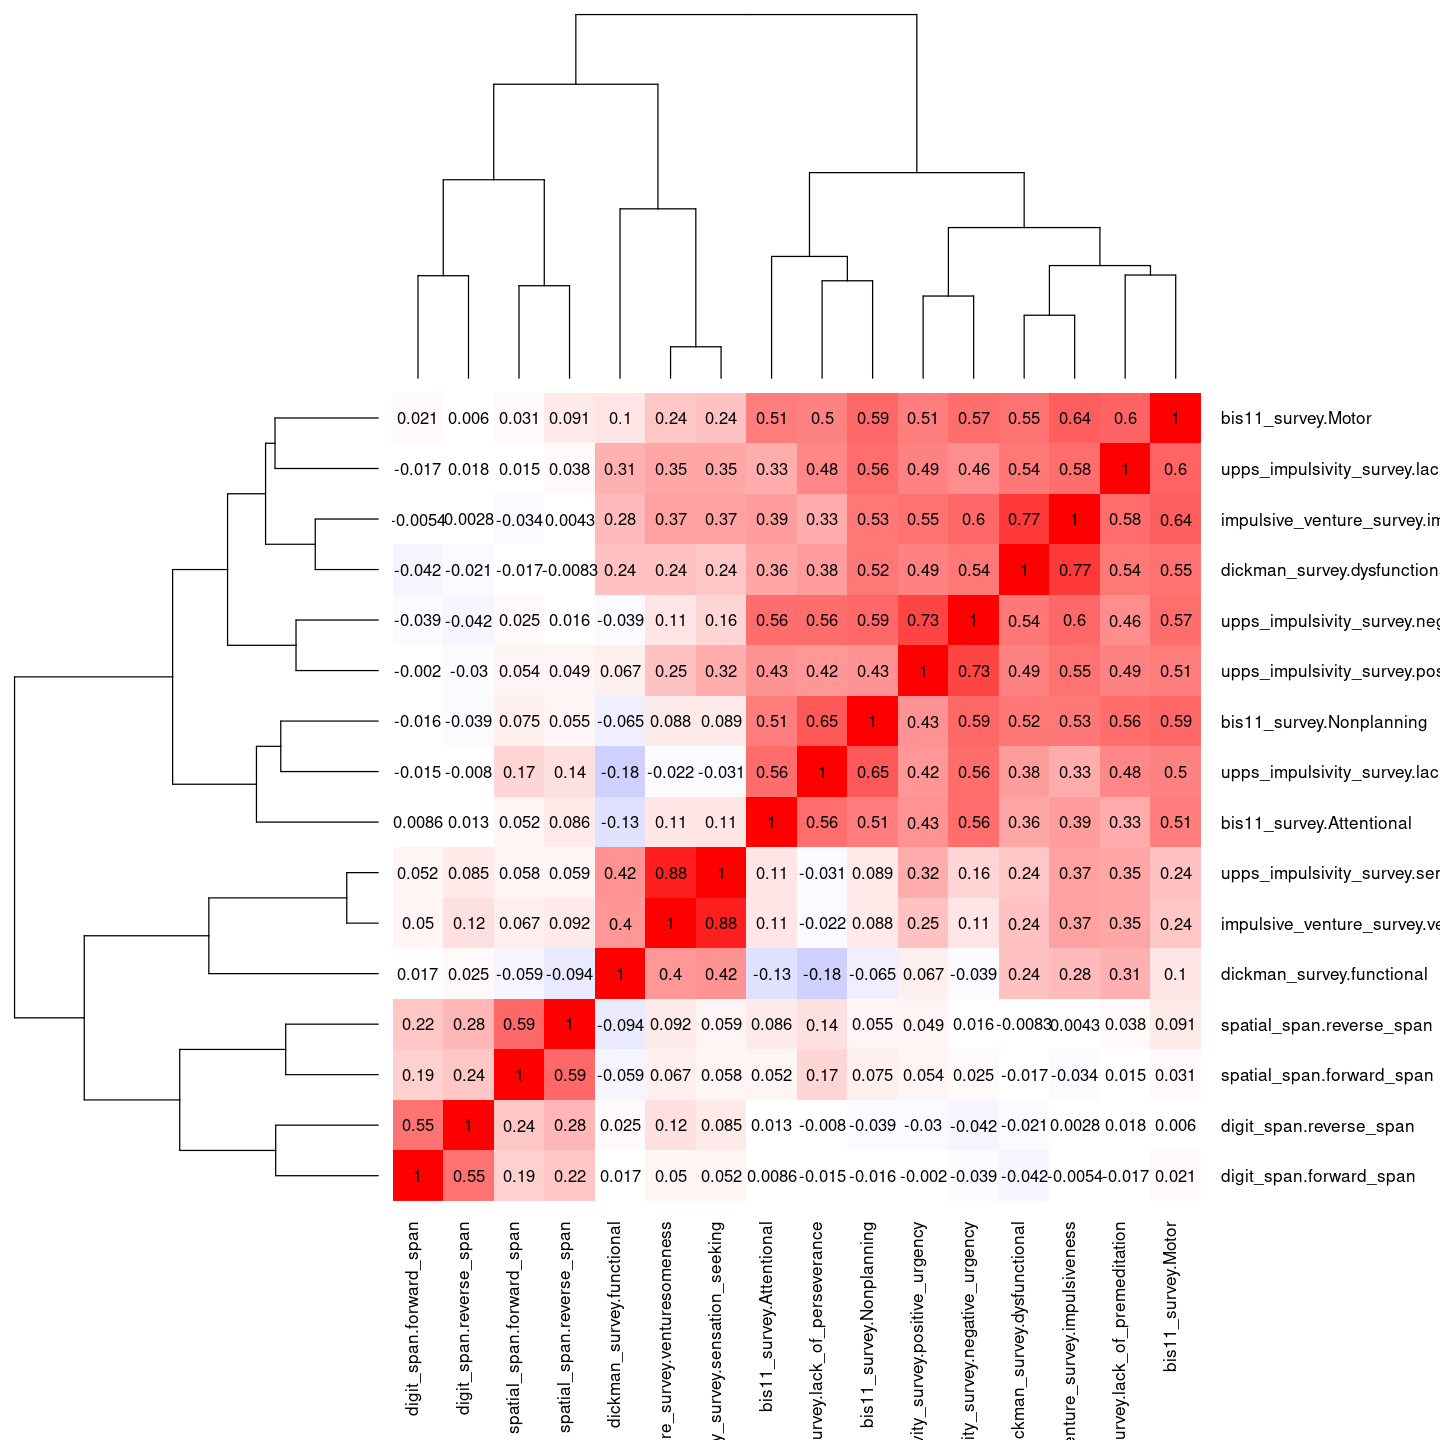

In [33]:
impulsivity_wm_measures = orig_data %>%
  dplyr::select(starts_with(c('bis11', 'dickman', 'impulsive_venture', 'upps', 'digit_span', 'spatial_span')))

names(impulsivity_wm_measures)
cc = cor(impulsivity_wm_measures)

library(repr)
options(repr.plot.width=12, repr.plot.height=12)
  par(mar=c(10,4,4,10)+0.1)

heatmap.2(cc, trace='none', cellnote=signif(cc, digits=2), notecol='black',
  notecex=1, col=bluered(100), key=FALSE, margins=c(12,12))


Here we see two things.  First we see that the working memory variables are clustered together, and are fairly distinct from the impulsivity measures.  Second, we see that there seem to be two clusters of variables within the impulsivity measures; the three that are separate seem to be related to sensation seeking, whereas the others are more related to dysfunctional aspects of impulsivity.

### Factor analysis for construct validation

One way to test for construct validity is to use *factor analysis*, which allows estimation of the underlying structure in a dataset.  Here we will just give a quick example; see [Chapter 16 of my statistics book](https://statsthinking21.github.io/statsthinking21-core-site/multivariate.html#dimensionality-reduction) for more on this.

Using *exploratory factor analysis* we can assess the degree to which the data exhibit structure consistent with a particular underlying generative model.  First, let's run the model and show the relationship between the latent variables and observed variables using three factors (which seems most reasonable given the correlations above):

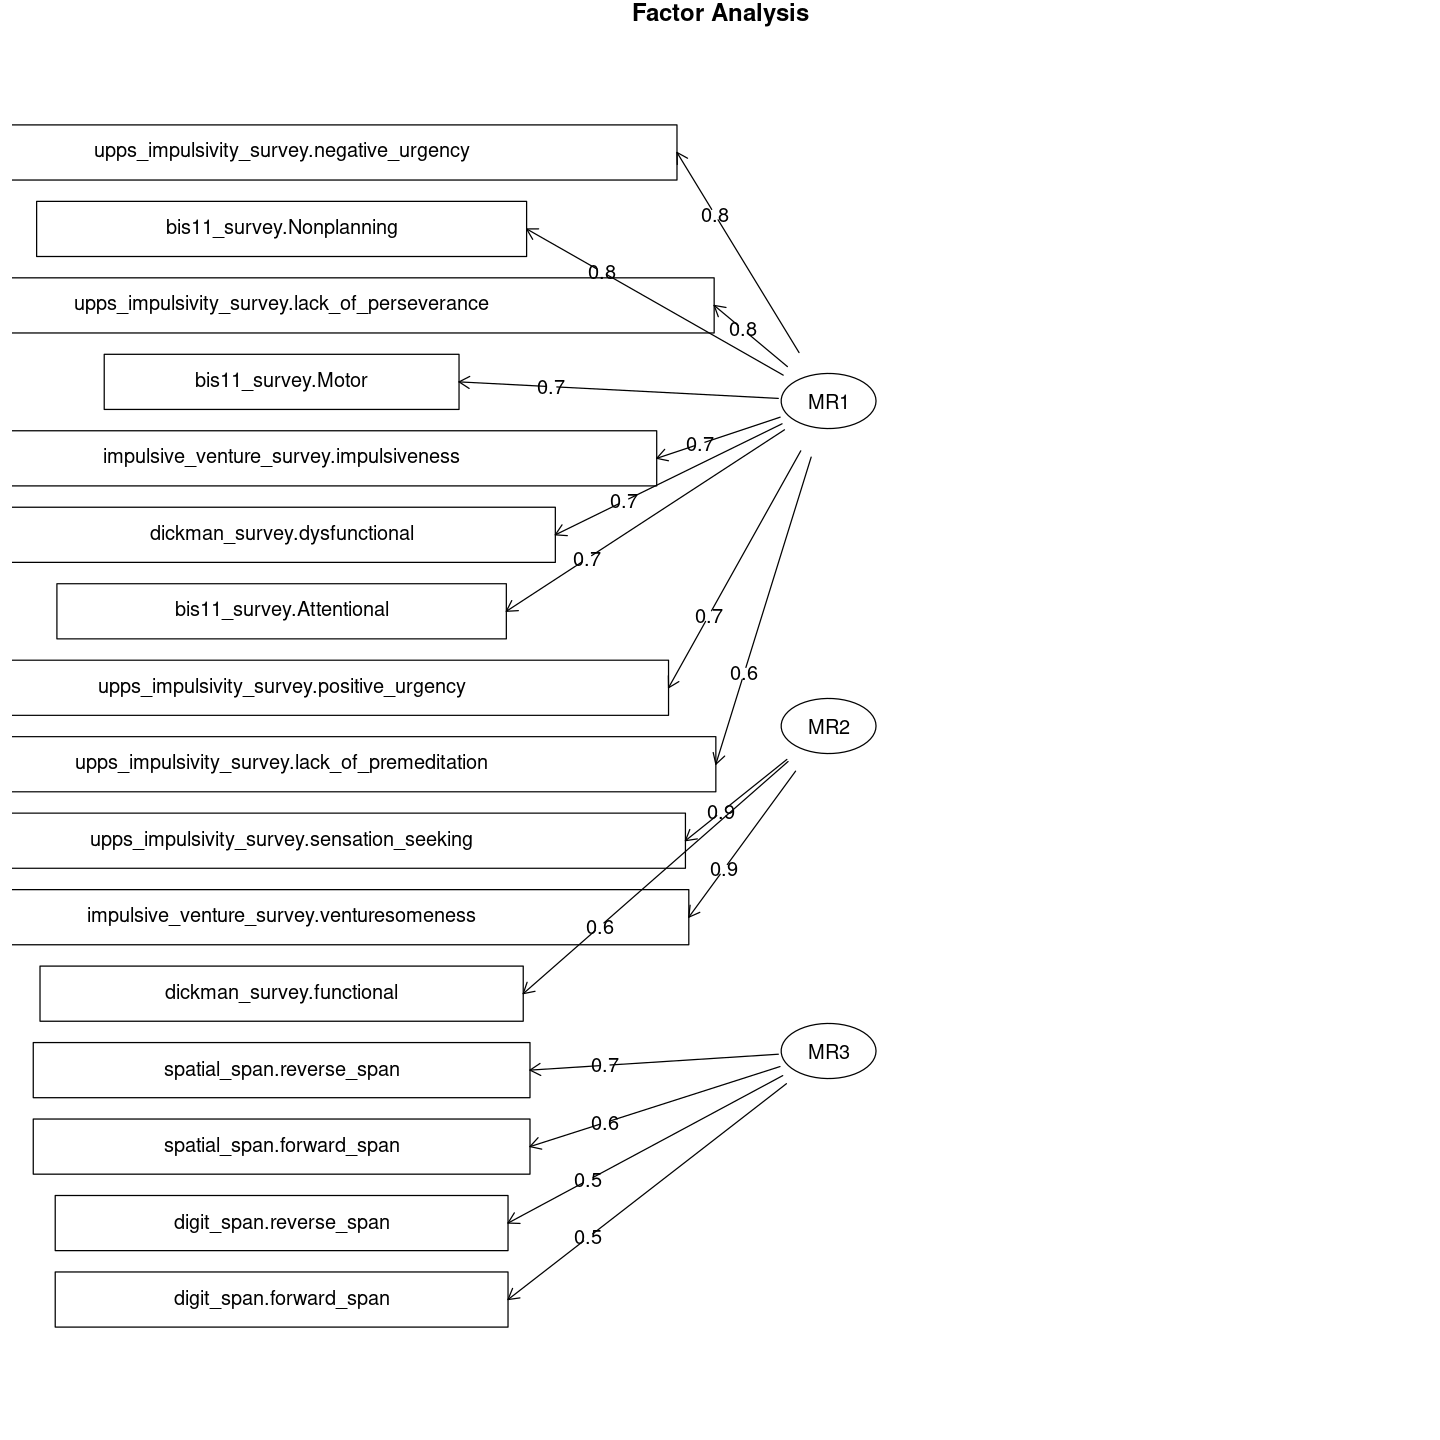

In [34]:
fa.diagram(fa(impulsivity_wm_measures, 3))

Here we see that the three latent variables map closely to the three clusters seen above.  Let's say that we want to compare the model with three factors to one with two factors. We can do this using a model comparison statistic called the *Bayesian Information Criterion* (BIC) whic quantifies the likelihood of the data given the model while also taking into account the complexity of the model. Smaller numbers of this are better, and in this case, the BIC for the three-factor model is substantially lower than the BIC for the two-factor model, demonstrating strong evidence that the three-factor model is a better fit to the data.

In [35]:
fa(impulsivity_wm_measures, 2)$BIC
fa(impulsivity_wm_measures, 3)$BIC



[1] 667.8249

[1] 395.7964

Using the BIC values we can also compute a Bayes factor, using an approximation developed by Wagenmakers ([2007](https://www.ejwagenmakers.com/2007/pValueProblems.pdf)):

In [36]:
BF_3_vs_2 = exp((fa(impulsivity_wm_measures, 3)$BIC - fa(impulsivity_wm_measures, 2)$BIC)/2)
BF_3_vs_2

[1] 8.50704e-60

This shows that there is overwhelming evidence in favor of the three-factor model.

Based on these results, we would conclude that there is good evidence for divergent validity between the working memory and impulsivity constructs, but that there is a lack of convergent validity for the entire set of impulsivity measures, reflecting the fact that the different measures seem to relate to two distinct underlying constructs.

### Predictive validity

Another type of validity is commonly known as *predictive validity*, which refers to the fact that a measure of a construct should be useful for predicting other outcomes that are putatively related. This is usually thought of as predicting outcomes in the future, though in the present example we will look at prediction of self-reported past behavior.  

Note that there is controversy about the use of the term *predict*.  We ([Poldrack et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7250718/)) and others have argued that the term prediction should be reserved for cases where the data being predicted were not included in the fitting of the statistical model; that is, they are "out of sample."  

**introduce cross-validation**

For the present example we will try to predict whether the likelihood of divorce is related to the psychological .  First we need to prepare the data:

In [59]:
gritdata = read_csv('../Data/NLS79/default.csv') %>%
  rename(
    PUBID_1997 = R0000100,
    YSAQ_354_1997 = R0357500,
    YSAQ_355_1997 = R0357600,
    YSAQ_356_1997 = R0357700,
    YSAQ_357_1997 = R0357800,
    KEY_SEX_1997 = R0536300,
    KEY_BDATE_M_1997 = R0536401,
    KEY_BDATE_Y_1997 = R0536402,
    P6_002_1997 = R0624000,
    P6_003_1997 = R0624100,
    P6_004_1997 = R0624200,
    P6_005_1997 = R0624300,
    CV_SAMPLE_TYPE_1997 = R1235800,
    KEY_RACE_ETHNICITY_1997 = R1482600,
    FP_PYFBEHS_1997 = R1487500,
    FP_PYMBEHS_1997 = R1487600,
    YSAQ_GRIT_1_2013 = T9039400,
    YSAQ_GRIT_2_2013 = T9039500,
    YSAQ_GRIT_3_2013 = T9039600,
    YSAQ_GRIT_4_2013 = T9039700,
    YSAQ_GRIT_5_2013 = T9039800,
    YSAQ_GRIT_6_2013 = T9039900,
    YSAQ_GRIT_7_2013 = T9040000,
    YSAQ_GRIT_8_2013 = T9040100,
    YSAQ_GRIT_1_2015 = U1028900,
    YSAQ_GRIT_2_2015 = U1029000,
    YSAQ_GRIT_3_2015 = U1029100,
    YSAQ_GRIT_4_2015 = U1029200,
    YSAQ_GRIT_5_2015 = U1029300,
    YSAQ_GRIT_6_2015 = U1029400,
    YSAQ_GRIT_7_2015 = U1029500,
    YSAQ_GRIT_8_2015 = U1029600,
    YEND_SAQ_GRIT_1_2017 = U2969100,
    YEND_SAQ_GRIT_2_2017 = U2969200,
    YEND_SAQ_GRIT_3_2017 = U2969300,
    YEND_SAQ_GRIT_4_2017 = U2969400,
    YEND_SAQ_GRIT_5_2017 = U2969500,
    YEND_SAQ_GRIT_6_2017 = U2969600,
    YEND_SAQ_GRIT_7_2017 = U2969700,
    YEND_SAQ_GRIT_8_2017 = U2969800,
    marital_status = U4954600
  ) %>%
    filter(marital_status >= 0) %>%
    mutate(
        marital_status = recode(marital_status,
                            `0` = "Never-married",
                            `1` = "Married",
                            `2` = "Separated",
                            `3` = "Divorced",
                            `4` = "Widowed"))



Rows: 8984 Columns: 41
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (41): R0000100, R0357500, R0357600, R0357700, R0357800, R0536300, R05364...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [61]:
table(gritdata$marital_status)


     Divorced       Married Never-married     Separated       Widowed 
          877          3133          2490           134            40 

In [37]:
orig_data_with_demog = merge(y=demog_data, x=orig_data, by = "subID", all.x = TRUE)

arrest_prediction_measures = orig_data_with_demog %>%
  dplyr::select(starts_with(c('everArrested', 'bis11', 'dickman', 'impulsive_venture', 'upps'))) %>%
  drop_na()

x = model.matrix(everArrested ~ ., arrest_prediction_measures)

y = arrest_prediction_measures %>%
  dplyr::select(everArrested) %>%
  pull()

Now we will fit a statistical model to the data. Since the `everArrested` variable is binary, we will use a logistic regression model.  

In [38]:
# the "." in the formula means to use all of the other variables
glm_result = glm(everArrested ~., data=arrest_prediction_measures, family=binomial)

# predict the probability of arrest
arrest_prediction_measures$p_response = predict(glm_result, arrest_prediction_measures, 'response')

# generate a binary prediction; if p > .5 then say yes, otherwise say no
arrest_prediction_measures$predicted = as.integer(arrest_prediction_measures$p_response > 0.5)


One way to assess the performance of binary prediction is through a *confusion matrix*, which shows the number of predicted versus actual outcomes.


| Actual \ Predicted | Positive | Negative |
|--------------------|----------|----------|
| Positive           | TP       | FN       |
| Negative           | FP       | TN       |




The `confusionMatrix` function also computes a number of different measures.

In [39]:
cm = confusionMatrix(data=as.factor(arrest_prediction_measures$predicted),
                reference = as.factor(arrest_prediction_measures$everArrested))
cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 400 109
         1   9   3
                                          
               Accuracy : 0.7735          
                 95% CI : (0.7351, 0.8088)
    No Information Rate : 0.785           
    P-Value [Acc > NIR] : 0.7575          
                                          
                  Kappa : 0.0071          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.97800         
            Specificity : 0.02679         
         Pos Pred Value : 0.78585         
         Neg Pred Value : 0.25000         
             Prevalence : 0.78503         
         Detection Rate : 0.76775         
   Detection Prevalence : 0.97697         
      Balanced Accuracy : 0.50239         
                                          
       'Positive' Class : 0               
                              

There are two numbers here that are important to understand.  *Sensitivity* is the likelihood of predicting a postiive outcome when it is present:

$
\text{sensitivity} = P(\text{positive predicted| positive true})
$

For example, take the COVID-19 rapid tests that we all came to know during the pandemic.  These have a sensitivity of about 65% ([Jegerlehner et al, 2021](https://pubmed.ncbi.nlm.nih.gov/34242764/)), which means that if someone has COVID, the test will be positive about 65% of the time.  

*Specificity*, on the other hand, is the likelihood of predictive a negative outcome when it is true.  

$
\text{specificity} = P(\text{negative predicted| negative true})
$


The specificity of the COVID-19 rapid tests was estimated to be 99.9%, meaning that for every 1000 people who take the test who are not infected, we would expect 1 false positive outcome.



### The Receiver Operating Characteristic (ROC) curve

The prediction performance of the model above was quite poor, with accuracy that was slightly worse than the *no-information rate*, which simply guesses that everyone has whichever is the most common label (which in this case it means that we guess that no one has been arrested).

The problem comes from the fact that while the model gave us a probability that each person had been arrested, we thresholded these at 0.5 to get our guesses.  If we had used a different threshold then we would have gotten a different answer; for example, if our threshold was very low then we would have guessed that almost everyone had been arrested, wheras with a very high threshold we would guess that no one has been arrested.  This is particularly a problem when the thing we are trying to predict is relatively rare, since the prediction model will often be pulled towards the more prevalent label.

A solution to this is to look at how the model performs across a broad range of thresholds that vary from high sensitivity and low specificity (i.e. having a high number of false positives), to high specificity and low sensitivity (i.e. having a high number of false negatives).  This is known as a *receiver operating characteristic*, or ROC, curve.   To obtain the ROC curve, we threshold the data at a range of different values (from 0.01 to 0.99 in steps of 0.01 for this example), and for each threshold we compute the sensitivity and specificity and plot them against each other.  If there is no predictive accuracy then we expect the sensitivity and specificity to add to 1, such that the plot will fall on the diagonal line.  If there is above-chance accuracy, then the plotted line will fall above the diagonal.  When we plot this for the arrest data, we see that in fact it does fall above the diagonal:

In [40]:
roc = c()

for (p_thresh in seq(0.01, 0.99, 0.01)){
  pred = as.integer(arrest_prediction_measures$p_response > p_thresh)
  cm_sim = confusionMatrix(data=factor(pred, levels=c(0, 1)),
                reference = factor(arrest_prediction_measures$everArrested, levels=c(0, 1)))
  roc = rbind(roc, c(p_thresh, cm_sim$byClass['Sensitivity'], cm_sim$byClass['Specificity']))
}

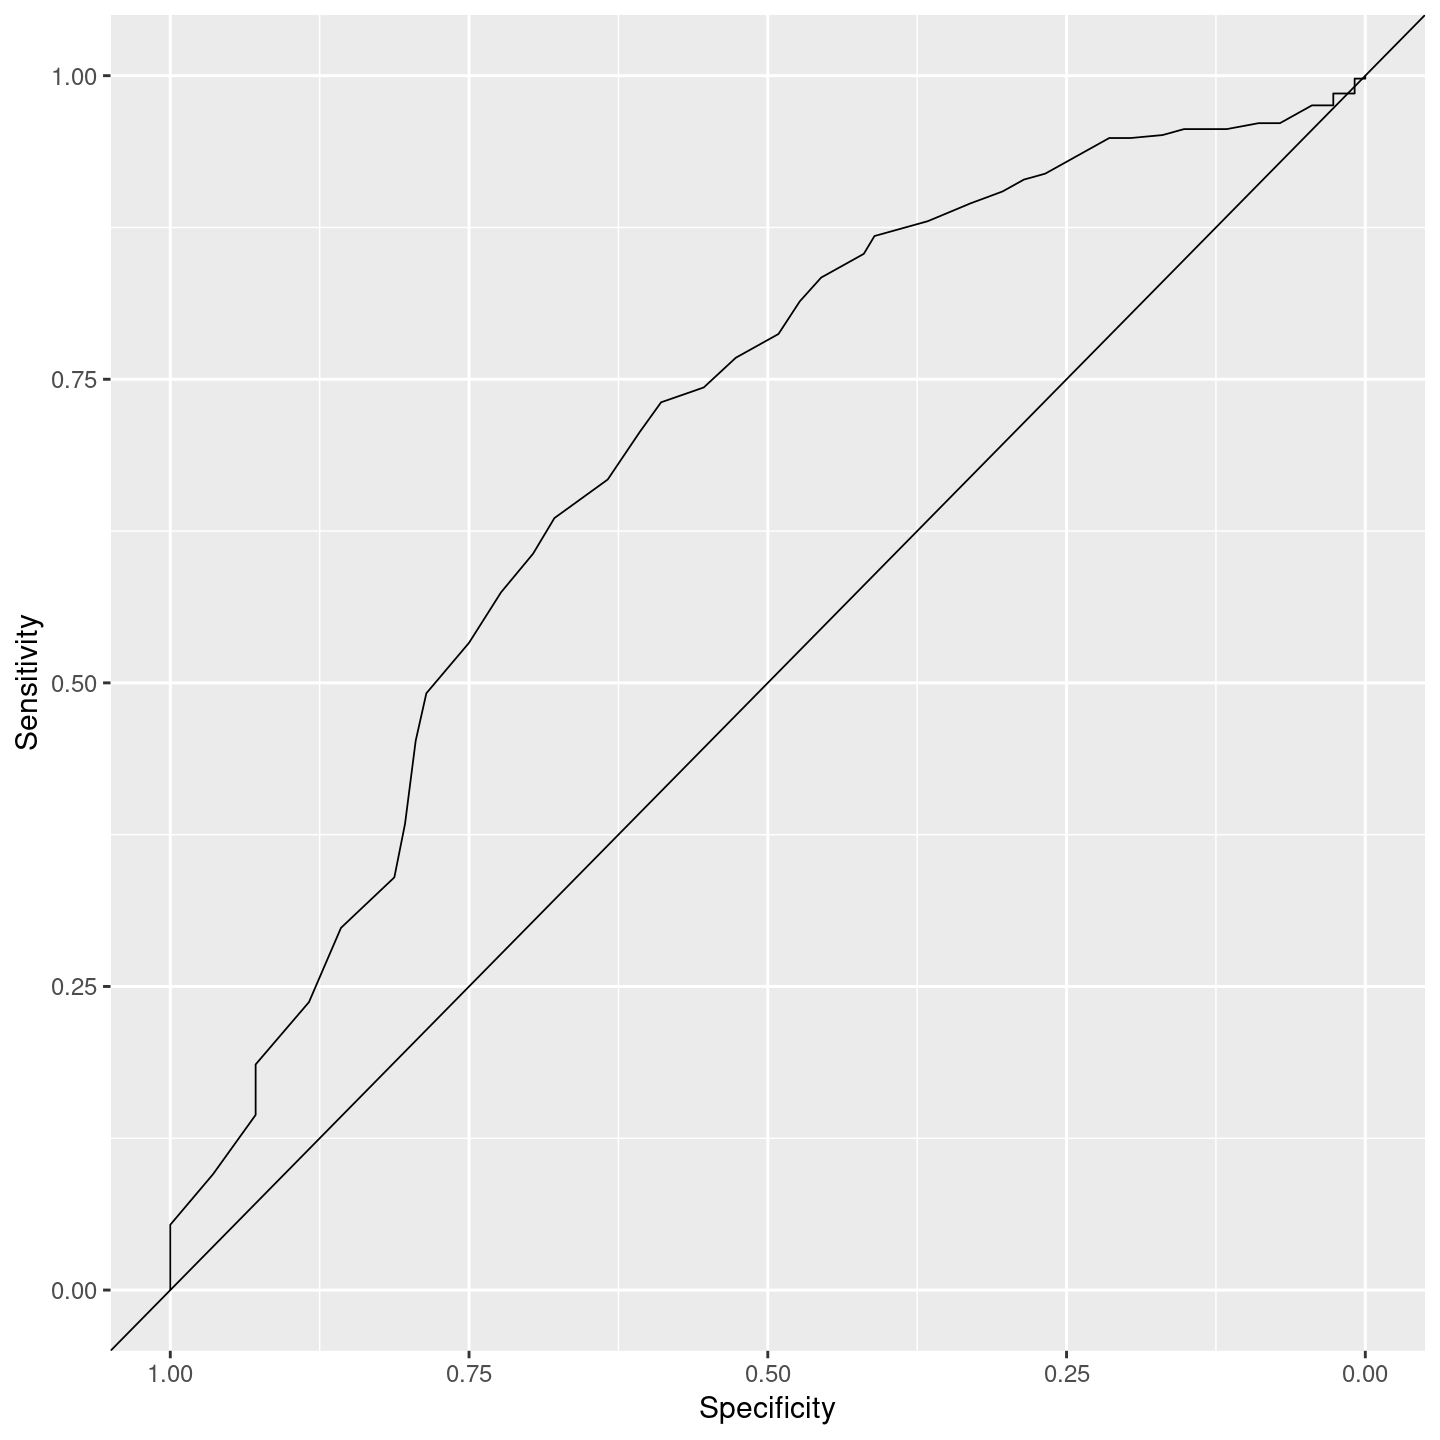

In [41]:
ggplot(data.frame(roc), aes(Specificity, Sensitivity)) +
  geom_line() +
  scale_x_reverse() +
  geom_abline(slope=1, intercept=1)

We would generallly use a function such as the `roc` function from the *pROC* library:

Setting levels: control = 0, case = 1

Setting direction: controls < cases



ERROR: Error in .progress == "none" && !.inform: 'length = 3' in coercion to 'logical(1)'


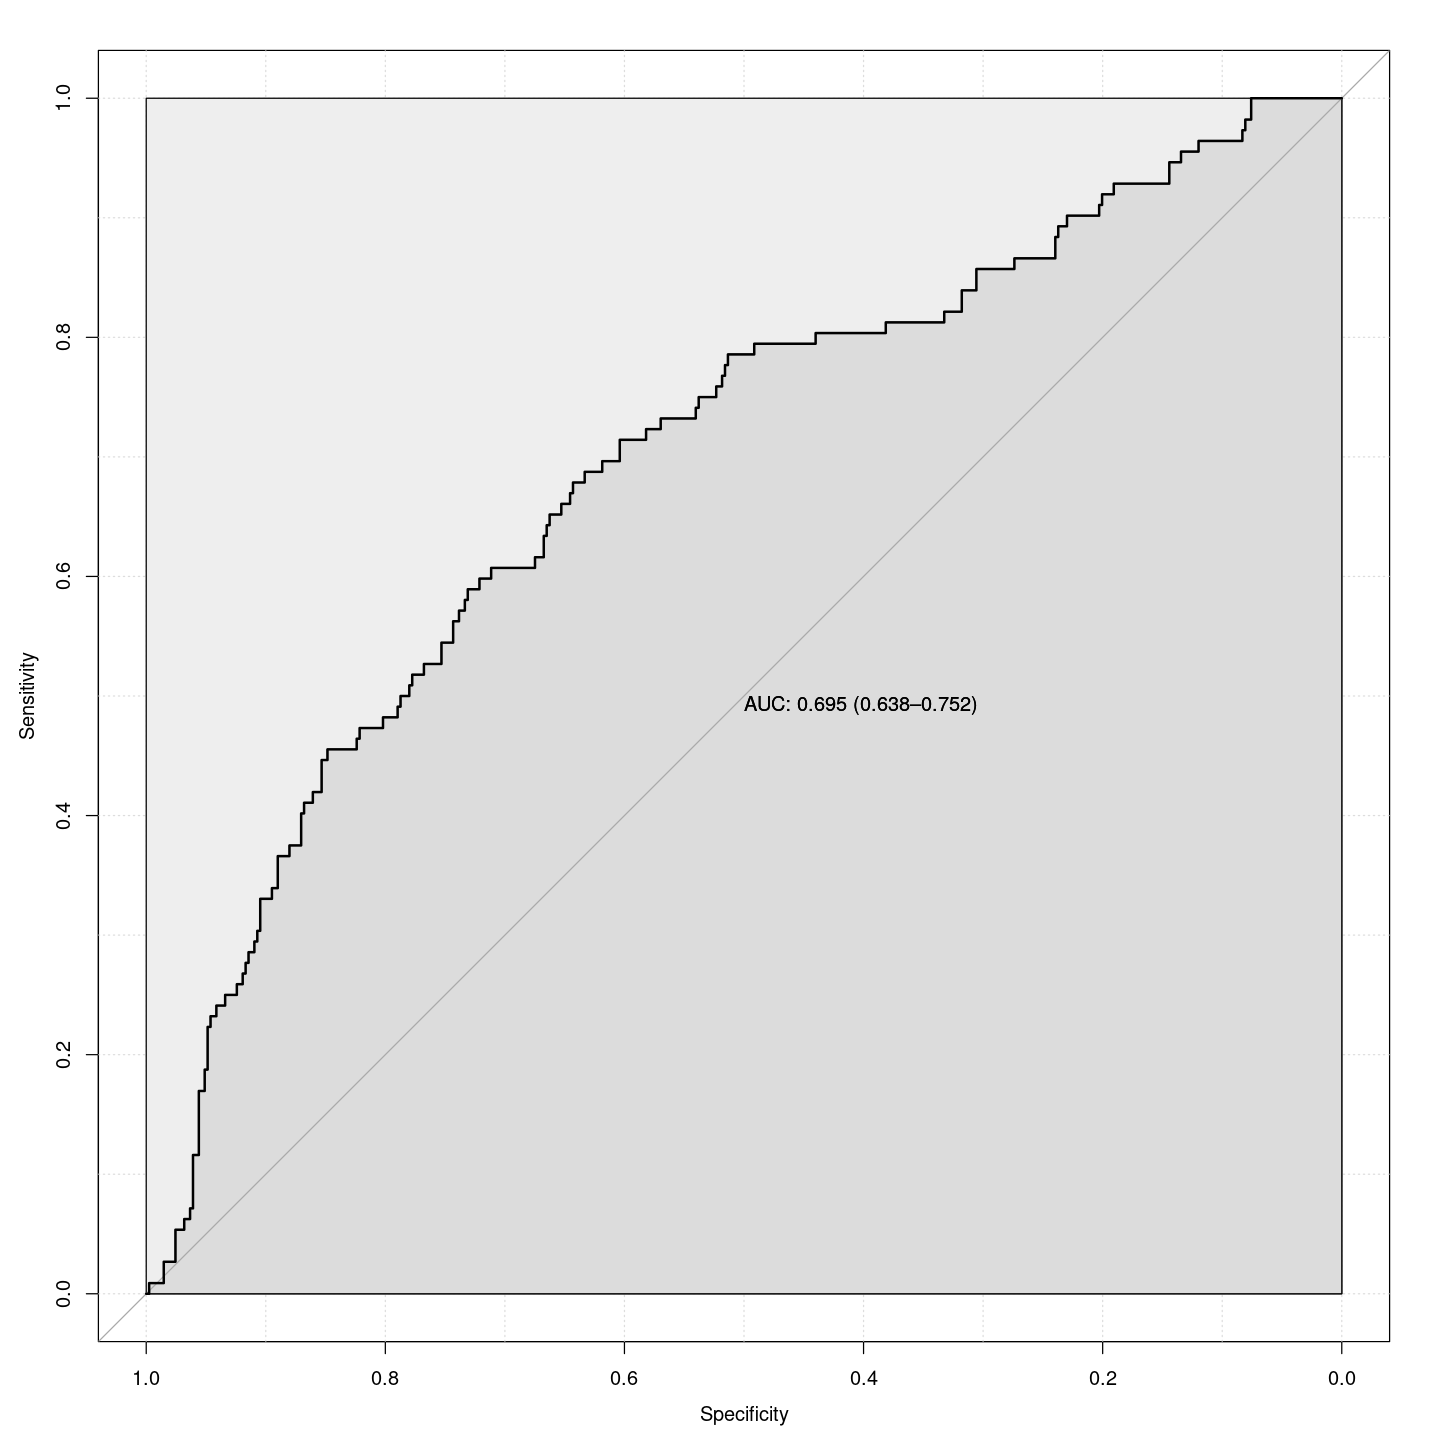

In [42]:
pROC_obj <- roc(arrest_prediction_measures,'everArrested', 'p_response',
            smoothed = TRUE,
            # arguments for ci
            ci=TRUE, ci.alpha=0.9, stratified=FALSE,
            # arguments for plot
            plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE)


sens.ci <- ci.se(pROC_obj)
plot(sens.ci, type="shape", col="lightblue")
## Warning in plot.ci.se(sens.ci, type = "shape", col = "lightblue"): Low
## definition shape.
#plot(sens.ci, type="bars")

This gives us a couple of useful things.

First, it estimates a confidence interval around the ROC curve, which helps us to determine whether it is significantly above the diagonal.

Second, it provides us with a measure of the *area under the curve*, or *AUC*.  This tells us what proportion of the area in the entire plot falls under the curve.  If there is no predictive accuracy and the ROC curve falls on the diagonal, then we expect the AUC to be about 0.5.  In this case it is 0.695, and the confidence interval does not include 0.5, so we can conclude that it is significantly better than chance.

If we wanted a p-value to test whether the AUC is better than chance, we could also obtain one by using randomization.  By randomly shuffling the actual outcome, we basically make the null hypothesis true (on average).  

If we do this once and plot the ROC curve, we see that it falls roughly on the line, with the confidence interval including 0.5.  

In [ ]:
arrest_prediction_measures = arrest_prediction_measures %>%
  mutate(everArrested_shuf = sample(everArrested))
pROC_obj_shuf <- roc(arrest_prediction_measures,'everArrested_shuf', 'p_response',
            smoothed = TRUE,
            # arguments for ci
            ci=TRUE, ci.alpha=0.9, stratified=FALSE,
            # arguments for plot
            plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE)


sens.ci <- ci.se(pROC_obj_shuf)
plot(sens.ci, type="shape", col="lightblue")
## Warning in plot.ci.se(sens.ci, type = "shape", col = "lightblue"): Low
## definition shape.
plot(sens.ci, type="bars")

To get an overall p-value, we would run this repeatedly with a random shuffle of the outcome variable, and on each time we record the estimate of AUC.  

In [ ]:
n_sims = 1000
sim_results = c()

sim_df = arrest_prediction_measures %>% dplyr::select(-c('p_response', 'predicted'))

for (i in 1:n_sims){
  glm_result = glm(everArrested ~., data=sim_df, family=binomial)
  sim_df$p_response = predict(glm_result, sim_df, 'response')

  pROC_obj_sim <- roc(sim_df,'everArrested', 'p_response',
            smoothed = TRUE, quiet=TRUE)
  sim_results = rbind(sim_results, c(pROC_obj_sim$auc, mean(sim_df$everArrested == (sim_df$p_response > 0.5))))
  sim_df$everArrested = sample(sim_df$everArrested)

}

sim_results_df = data.frame(sim_results)
names(sim_results_df) = c('auc', 'acc')

We can then compute the p-value by comparing our observed AUC value to those for the shuffled runs:

In [ ]:
ggplot(sim_results_df, aes(x=auc)) +
  geom_histogram() +
  geom_vline(xintercept = pROC_obj$auc, color='blue') +
  ggtitle(sprintf('empirical p-value: %0.3f', mean(sim_results_df$auc >= pROC_obj$auc)))